In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ROOT_DIR = "./"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Regresion Logistica Multiclase

In [3]:
from scipy.io import loadmat

data = loadmat(os.path.join(DATA_PATH ,'ex3data1.mat'))
X = data['X']
x = data['X']
y = np.squeeze(data['y']) # the target variable vector is labeled with 'y' inside the file
m = X.shape[0] # 5000 examples
n = X.shape[1] # 400 features
num_etiquetas = 9 # digits from 0 to 9

X = np.hstack([np.ones([m,1]),X]) #add columns of 1s

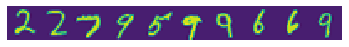

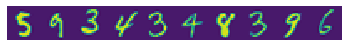

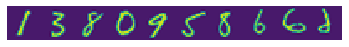

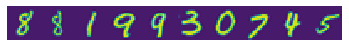

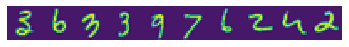

In [4]:
for i in range(5):
    sample = np.random.choice(X.shape[0], 10)
    plt.imshow(X[sample, 1:].reshape(-1, 20).T)
    plt.axis('off')
    plt.show()

Usamos de nuevo las funciones de coste y gradiente de la Regresion Logistica

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def cost(theta, X, Y, lambda_param):
    H = sigmoid(np.dot(X, theta))
    H[H == 1] = 0.9999 #np.log(1)=0 -> division error
    Aux1 = -(np.dot(np.log(H).T, Y) + np.dot((np.log(1 - H)).T, (1 - Y)))/len(X)
    Aux2 = (lambda_param/(2*len(X))) * np.sum(theta**2)
    return Aux1 + Aux2

def gradient(theta, X, Y, lambda_param):
    Aux = (np.dot(X.T, (sigmoid(np.dot(X, theta.T)) - Y))) / len(X)
    return Aux.T + ((lambda_param/len(X))*theta)

Para hacer un clasificador multi clase usamos el metodo One vs All  
Consiste en entrenar un clasificador para cada etiqueta y al predecir comparar la probabilidad con la del resto

In [6]:
import scipy.optimize as opt
def oneVsAll(X, y, num_etiquetas, reg):
    """
    oneVsAll entrena varios clasificadores por regresion logistica con termino
    de regularizacion 'reg' y devuelve el resultado en una matriz, done
    la fila i-esima corresponde al clasificador de la etiqueta i-esima
    """
    gd_thetas = np.zeros(shape=(m, len(X[0]))) #(5000, 401)
    for i in range(num_etiquetas):
        # we are building the classifier for each digit i in each loop

        # theta is a 401x1 vector (400+1), because of x0s = 1 column
        theta = np.zeros(np.shape(X[0]))

        label = (y == i).astype(int) #valores de y para cada clasificador
        
        result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, label, lambda_param))
        gd_thetas[i,:] = result[0]
    
    return gd_thetas

In [7]:
lambda_param = 0.1
classifiers = oneVsAll(X,y, 10, lambda_param)

In [8]:
probs = sigmoid(X @ classifiers.T) #probabilidad para cada classificador
y_pred = probs.argmax(axis=1) #cogemos la probabilidad maxima de cada clasificador

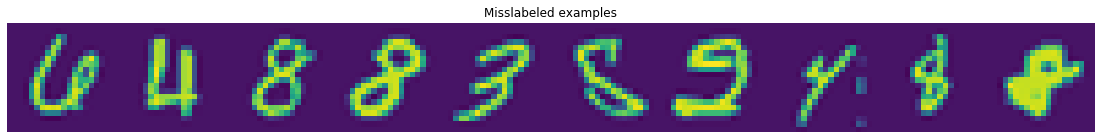

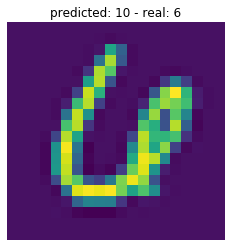

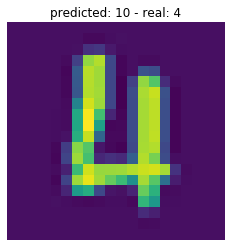

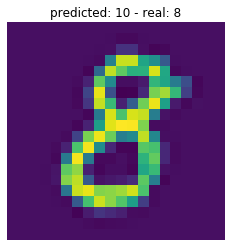

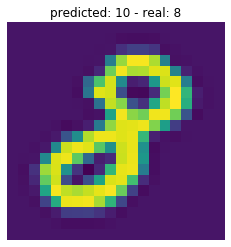

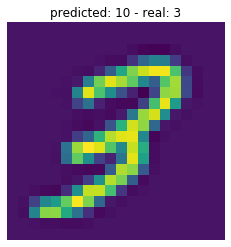

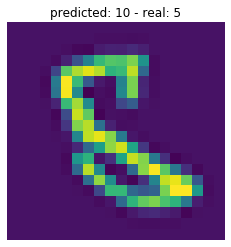

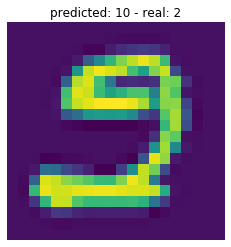

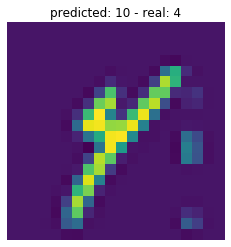

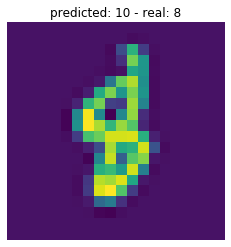

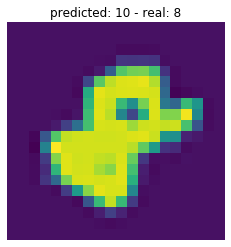

In [9]:
misslabeled = [y_pred != y]

digits = np.where(misslabeled)[1]
sample = digits[np.random.choice(digits.shape[0], 10)]
plt.figure(figsize = (100,2))
plt.imshow(X[sample, 1:].reshape(-1, 20).T)
plt.axis('off')
plt.title("Misslabeled examples")
plt.show()

#La etiqueta 10 corresponde al valor 0
for digit in sample:
    plt.imshow(X[digit, 1:].reshape(-1, 20).T)
    plt.axis('off')
    plt.title("predicted: {} - real: {}".format(y_pred[digit], y[digit]))
    plt.show()

f1_score: 0.9238520079244267
accuracy: 0.9184


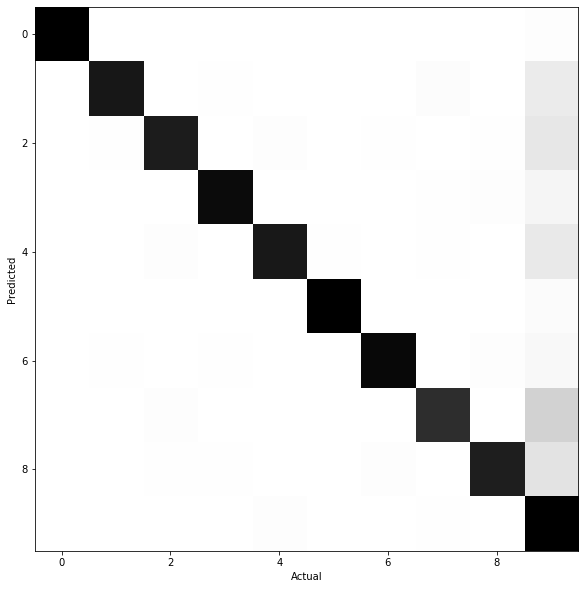

In [10]:
from sklearn.metrics import confusion_matrix, f1_score
cm = confusion_matrix(y, y_pred)

plt.figure(figsize = (10,10))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.imshow(cm, cmap='binary')
print("f1_score:", f1_score(y, y_pred, average='weighted'))
print("accuracy:", np.mean(y_pred == y))

# Redes Neuronales

![NN](img/nn.PNG "Red Neuronal")

## Red neuronal ya entrenada

Al estar los pesos de la red ya entrenados no necesitaremos una funcion para reducir el coste, simplemente necesitaremos una funcion de propagacion hacia delante

In [11]:
weights = loadmat(os.path.join(DATA_PATH ,'ex3weights.mat'))
theta1 , theta2 = weights['Theta1'], weights['Theta2']

## Forward Propagation
$ g(z) = sigmoid(z) = \dfrac{1}{1+ e^{-z}}$  
$ a^{(1)} = x$ add $a_{0}^{(1)}$    
$ a^{(2)} = g(\Theta^{(1)}a^{(1)}) $ add $a_{0}^{(2)}$  
$ h_{\theta}(x) = a^{(3)} = g(\Theta^{(2)}a^{(2)})$  

In [12]:
#Already added row of 1s in X
def forward_propagation(X, theta1, theta2):
    a_2 = sigmoid(theta1 @ X.T)
    a_2 = np.vstack([np.ones([1,a_2.shape[1]]),a_2]) #add row of 1s
    a_3 = sigmoid(theta2 @ a_2)
    return a_3

$ h_{\theta}(x) $ tiene una dimension de $(10x5000)$  
Por lo tanto para cada ejemplo de prueba tenemos 10 probabilidades, una para cada numero  
Cogeremos simplemente la que de valor maximo para cada numero

In [13]:
neural_pred = forward_propagation(X, theta1, theta2).argmax(axis=0)+1

Al obtener la matriz de confusion podemos ver como la diagonal nos dice que la mayoria han sido acertados  
Y los azules con mayor brillo nos dice donde ha fallado mas la red neuronal

f1_score: 0.9751766844000045
accuracy: 0.9752


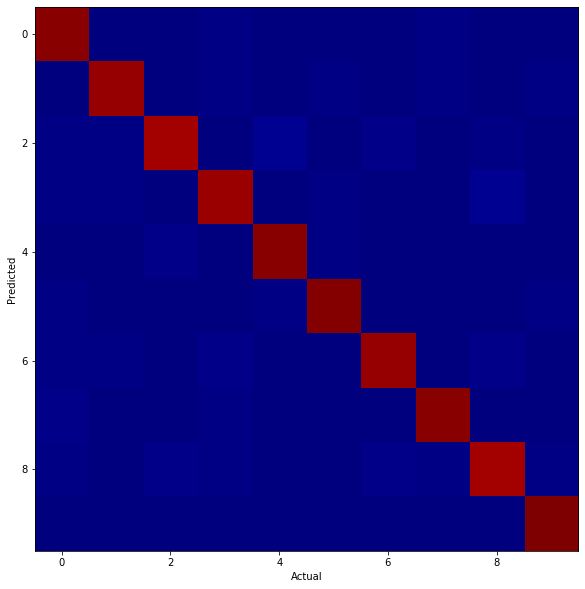

In [14]:
print("f1_score:", f1_score(y, neural_pred, average='weighted'))
print("accuracy:", np.mean(neural_pred == y))

plt.figure(figsize = (10,10))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.imshow(confusion_matrix(y, neural_pred), cmap='jet')
plt.show()